## CVU Open and Reproducible Research Computing (Fall 2022)

### Assignment Notebook: Time Series Analysis

#### 1. Install the `bmi_nwis` library (if it's not installed already)

In [1]:
#!pip install bmi_nwis

#### 2. Import the libraries required for the assignment

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataretrieval.nwis as nwis

output_pkl_file = 'streamflow_data_'

#### 3a. Choose one of the following USGS stream gages to analyze

Uncomment __one__ of the following `site_id` variable declarations. Leave `my_start_date` and `my_end_date` unchanged. All of the sites below have at least 40 years of record. Only the Cache la Poudre has less than 50. 

In [3]:
# site_id = '13185000' # Boise River at Twin Springs
# site_id = '13139510' # Big Wood River at Hailey
# site_id = '13246000' # North Fork of the Payette near Banks
site_id = '13042500' # Henry's Fork Near Island Park
# site_id = '06752260' # Cache La Poudre River near Fort Collins (CO)
# site_id = '09085000' # Roaring Fork River at Glenwood Springs (CO)

my_start_date = '1970-10-01'
my_end_date = '2020-09-30'

#### 4. Get the Flow Data

In [4]:
df_flow = nwis.get_record(sites=site_id, service='dv', 
                          start=my_start_date, end=my_end_date)
df_flow

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
1970-10-01 00:00:00+00:00,669.0,A,13042500
1970-10-02 00:00:00+00:00,658.0,A,13042500
1970-10-03 00:00:00+00:00,658.0,A,13042500
1970-10-04 00:00:00+00:00,658.0,A,13042500
1970-10-05 00:00:00+00:00,653.0,A,13042500
...,...,...,...
2020-09-26 00:00:00+00:00,331.0,A,13042500
2020-09-27 00:00:00+00:00,334.0,A,13042500
2020-09-28 00:00:00+00:00,334.0,A,13042500


#### 5. Plot the Data

Text(0, 0.5, 'Discharge (ft${}^3$/s)')

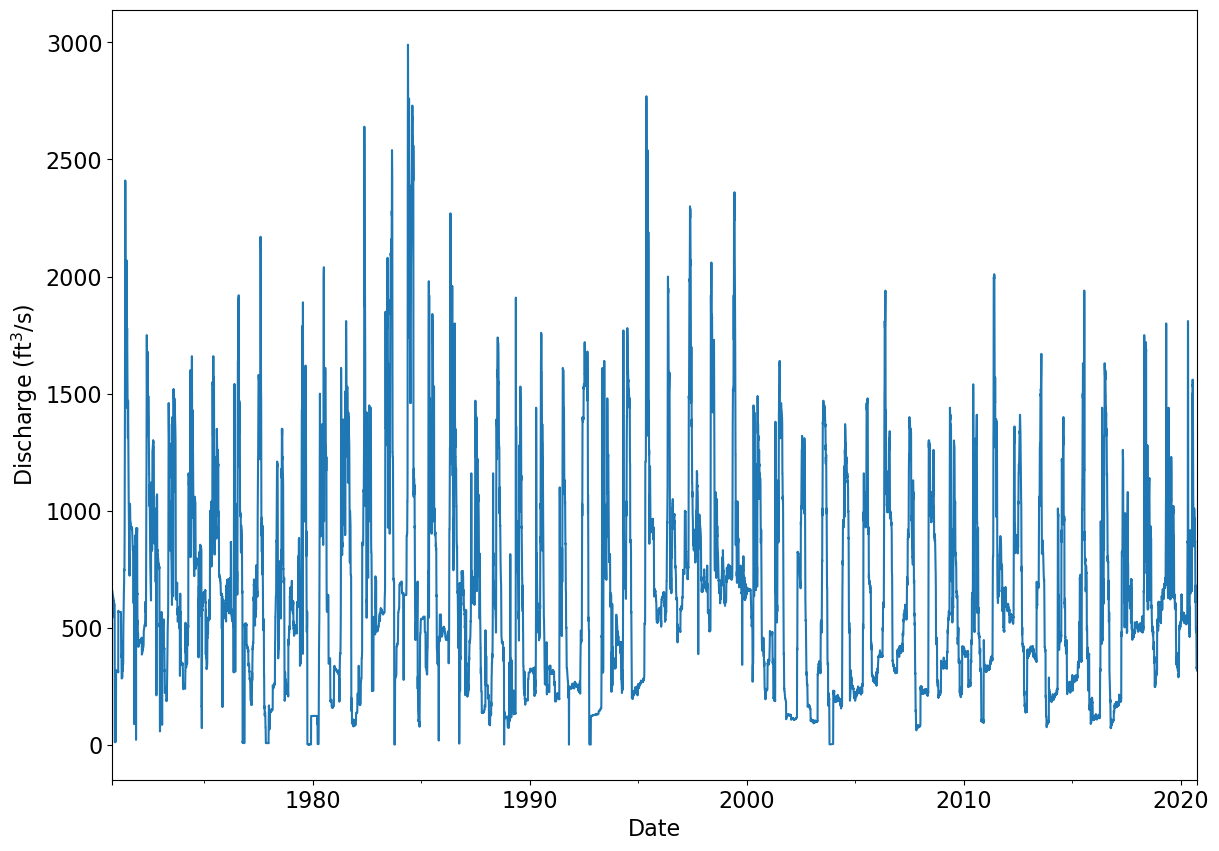

In [5]:
plt.rcParams.update({'font.size': 16})

ax1 = df_flow['00060_Mean'].plot(x='datetime', figsize=(14,10))

ax1.set_xlabel('Date')
ax1.set_ylabel('Discharge (ft${}^3$/s)')

#### 6. Wrangle the Data into a `pandas` DataFrame object

Steps: 
* Get the dates and streamflow out of the object returned by our call to `Nwis.nwis()`
* Convert the streamflow in ft${}^3$/s to m${}^3$/s
* Create a water year vector so we can analyze data by water year
* Create a `pandas.DataFrame()` with the data

In [6]:
# Get the dates and convert them to a Pandas datetime object
dates = df_flow.index
dates = pd.DatetimeIndex(dates) 

# Get the streamflow in ft^3/s as a numerical array and create one that is the same values but in m^3/s
Q_cfs = df_flow['00060_Mean'].values
Q_cms = Q_cfs / (3.2808**3)

# Create a water year vector by getting the year for every streamflow observation, checking the 
# associated month of that observation and then – if that month is October (10) or onward – add
# 1 to the water year
WY = df_flow.index.year.values
WY[dates.month>=10] += 1

# Create a pandas DataFrame from these variables
df = pd.DataFrame()
df['Dates'] = dates
df['WaterYear'] = WY
df['Discharge_cfs'] = Q_cfs
df['Discharge_cms'] = Q_cms

# Rebuild the index to be able to use the pd.DataFrame.groupby() method
df.index = pd.to_datetime(df['Dates'],'%y-%m-%d')

# Save to a pickle file
# Question: What's going on with the file name? 
df.to_pickle(output_pkl_file+site_id+'.pkl')

# Show the dataframe we've created
df

,Dates,WaterYear,Discharge_cfs,Discharge_cms
Dates,,,,
1970-10-01 00:00:00+00:00,1970-10-01 00:00:00+00:00,1971,669.0,18.944661
1970-10-02 00:00:00+00:00,1970-10-02 00:00:00+00:00,1971,658.0,18.633165
1970-10-03 00:00:00+00:00,1970-10-03 00:00:00+00:00,1971,658.0,18.633165
1970-10-04 00:00:00+00:00,1970-10-04 00:00:00+00:00,1971,658.0,18.633165
1970-10-05 00:00:00+00:00,1970-10-05 00:00:00+00:00,1971,653.0,18.491575
...,...,...,...,...
2020-09-26 00:00:00+00:00,2020-09-26 00:00:00+00:00,2020,331.0,9.373218
2020-09-27 00:00:00+00:00,2020-09-27 00:00:00+00:00,2020,334.0,9.458172
2020-09-28 00:00:00+00:00,2020-09-28 00:00:00+00:00,2020,334.0,9.458172


#### 7. Compute the Seasonal Cycle and Plot

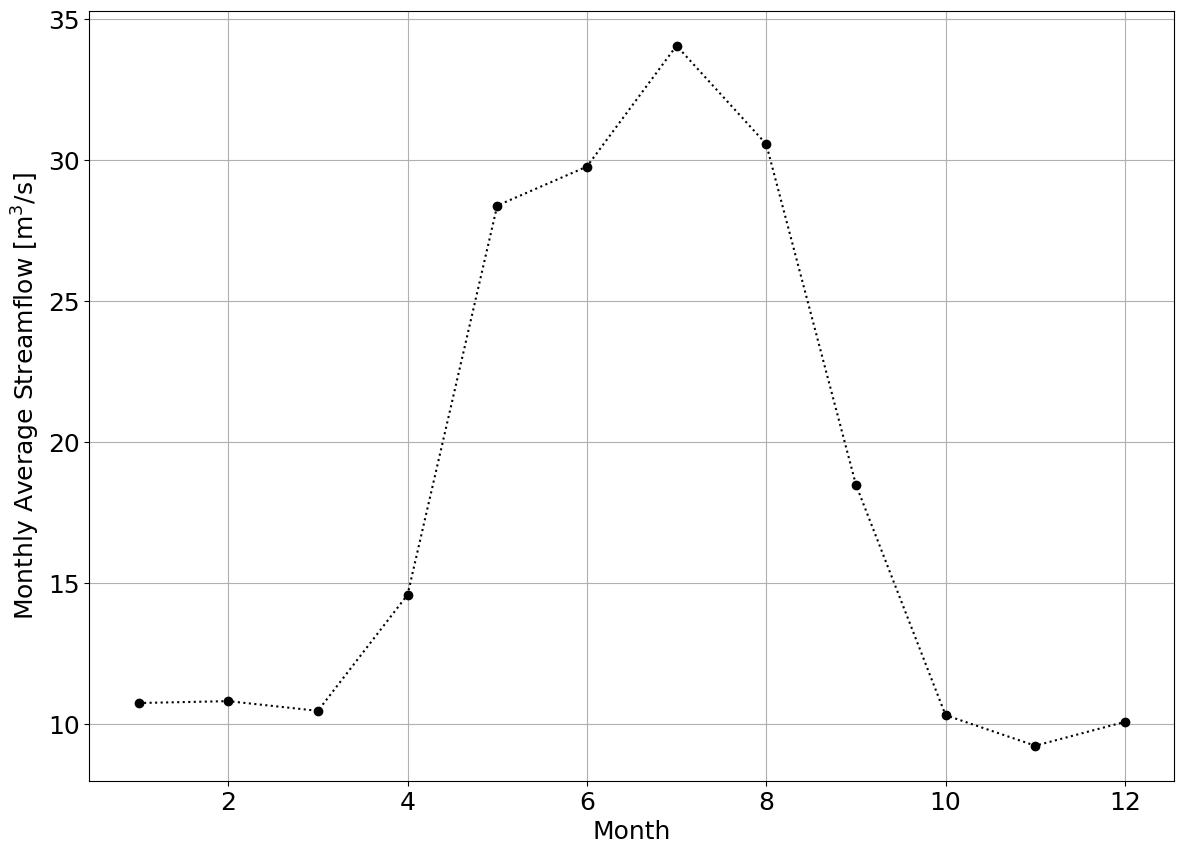

In [7]:
q_seasonal = df['Discharge_cms'].groupby(by=df.index.month).mean().values

plt.figure(figsize=(14,10))
plt.rcParams.update({'font.size': 18}) # Increase the font size
plt.plot((np.arange(q_seasonal.size)+1),q_seasonal,'ko:')
plt.xlabel('Month')
plt.ylabel('Monthly Average Streamflow [m${}^3$/s]')
plt.grid()
plt.show()

## Instructions
---

1. Download this notebook into the folder for your repository for this module by opening a terminal window, navigating to your repository folder and issuing the command `curl -OL https://raw.githubusercontent.com/LejoFlores/OpenResearchComputing/main/mod02/mod02_assignment.ipynb`. Or, [click on this link](https://raw.githubusercontent.com/LejoFlores/OpenResearchComputing/main/mod02/mod02_assignment.ipynb) and save the page to your local repository.  
2. Verify that the notebook runs to this point 
3. Go back and change the `site_id` variable to a gage of your choosing by commenting out the current gage selected and uncommenting the gage you would like to investigate. Then in the Jupyter Lab menu go to "Kernel > Restart Kernel and Clear All Outputs" and click "Restart" when prompted
4. Re-run the notebook to this point
5. Now group the streamflow data by `WaterYear` and get the maximum streamflow value for each Water Year. You will need to use the `.groupby()` followed by the `.max()` methods. This should be very similar to the commands used to find the seasonal cycle above, but be sure to make sure to group by Water Year! Store the output of that operation in a variable called `Q_ams`. Print the output of `Q_ams` to see which years were associated with the lowest 5 and highest 5 annual maximum streamflows. __Note:__ See this [DataFrame.groupby()](https://www.geeksforgeeks.org/pandas-groupby/) and [DataFrame.max()](https://www.geeksforgeeks.org/python-pandas-dataframe-max/) documentation for help. 
6. Now sort the annual maximum series in ___descending order___ using the `.sort_values()` method. Use the `.values` to save these values to a numpy array. __Note:__ See this [DataFrame.sort_values()](https://www.geeksforgeeks.org/python-pandas-dataframe-sort_values-set-1/) and [DataFrame.values](https://www.geeksforgeeks.org/python-pandas-dataframe-values/) documentation for help. 
7. Compute the Weibull plotting position value for each streamflow value. The Weibull series is calculated using the formula:

    $$
    p_i = \frac{r_i}{n+1},
    $$

    where $r_i$ is the rank of the $i$th observation, $n$ is the number of annual maximum observations, and $p_i$ is the exceedance probability. Use the numpy command `np.arange()` method and the `.size` attribute on your annual maximum series array to create an array of ranks associated with each annual maximum value.
8. Create a presentation quality plot showing the annual maximum streamflows on the x-axis and the exceedance probability on the y axis. __Note:__ See this [numpy.arange()](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) and [numpy.size()](https://numpy.org/doc/stable/reference/generated/numpy.broadcast.size.html) documentation for help. 
9. The $T$-year recurrence interval is associated with an exceedance probability of $p$ which is calculated using:

    $$ 
    p = \frac{1}{T} 
    $$

    Calculate the values of the 20- and 50- year recurrence interval events directly from the Weibull plotting position values by using the numpy `np.interp()` function, which does a very basic interpolation (there are more sophisticated ones, but this is sufficient for now). __Note:__ See this [numpy.interp()](https://www.geeksforgeeks.org/numpy-interp-function-python/) documentation for help.  

In [8]:
Q_ams = df["Discharge_cms"].groupby(by=df.WaterYear).max().values
Q_ams

array([68.24608987, 49.55628933, 43.04317702, 47.00768016, 47.00768016,
       54.37032886, 61.44979877, 38.22913748, 53.52079247, 57.76847442,
       51.2553621 , 74.75920219, 71.92741422, 84.67046005, 56.06940164,
       64.28158673, 41.62728304, 49.27311053, 54.08715007, 49.83946812,
       45.59178618, 48.70675294, 46.44132257, 50.40582572, 78.44052654,
       56.63575923, 65.13112312, 58.33483201, 66.83019589, 42.19364063,
       46.44132257, 37.37960109, 41.62728304, 38.79549507, 41.91046183,
       54.93668645, 39.64503146, 36.8132435 , 40.77774665, 43.60953461,
       56.91893803, 39.92821026, 47.29085896, 39.64503146, 54.93668645,
       46.15814377, 35.68052832, 49.55628933, 50.97218331, 51.2553621 ])

In [9]:
maxQ = pd.DataFrame()
maxQ["ams"] = Q_ams
maxQ
maxQ.sort_values(by = ["ams"], ascending = False, ignore_index = True,inplace = True)
maxQ

,ams
0,84.670460
1,78.440527
2,74.759202
3,71.927414
4,68.246090
5,66.830196
6,65.131123
7,64.281587
8,61.449799
9,58.334832


In [10]:
Q_ams_sort = maxQ["ams"].values
Q_ams_sort

array([84.67046005, 78.44052654, 74.75920219, 71.92741422, 68.24608987,
       66.83019589, 65.13112312, 64.28158673, 61.44979877, 58.33483201,
       57.76847442, 56.91893803, 56.63575923, 56.06940164, 54.93668645,
       54.93668645, 54.37032886, 54.08715007, 53.52079247, 51.2553621 ,
       51.2553621 , 50.97218331, 50.40582572, 49.83946812, 49.55628933,
       49.55628933, 49.27311053, 48.70675294, 47.29085896, 47.00768016,
       47.00768016, 46.44132257, 46.44132257, 46.15814377, 45.59178618,
       43.60953461, 43.04317702, 42.19364063, 41.91046183, 41.62728304,
       41.62728304, 40.77774665, 39.92821026, 39.64503146, 39.64503146,
       38.79549507, 38.22913748, 37.37960109, 36.8132435 , 35.68052832])

In [11]:
excDF = pd.DataFrame()
excDF["ams_discharge"] = Q_ams_sort
excDF


,ams_discharge
0,84.670460
1,78.440527
2,74.759202
3,71.927414
4,68.246090
5,66.830196
6,65.131123
7,64.281587
8,61.449799
9,58.334832


In [12]:
excDF.insert(0, "rank", range(1, 51))
excDF


,rank,ams_discharge
0,1,84.670460
1,2,78.440527
2,3,74.759202
3,4,71.927414
4,5,68.246090
5,6,66.830196
6,7,65.131123
7,8,64.281587
8,9,61.449799
9,10,58.334832


In [13]:
excDF["weibull_p"] = excDF["rank"] / 51
excDF

,rank,ams_discharge,weibull_p
0,1,84.670460,0.019608
1,2,78.440527,0.039216
2,3,74.759202,0.058824
3,4,71.927414,0.078431
4,5,68.246090,0.098039
5,6,66.830196,0.117647
6,7,65.131123,0.137255
7,8,64.281587,0.156863
8,9,61.449799,0.176471
9,10,58.334832,0.196078


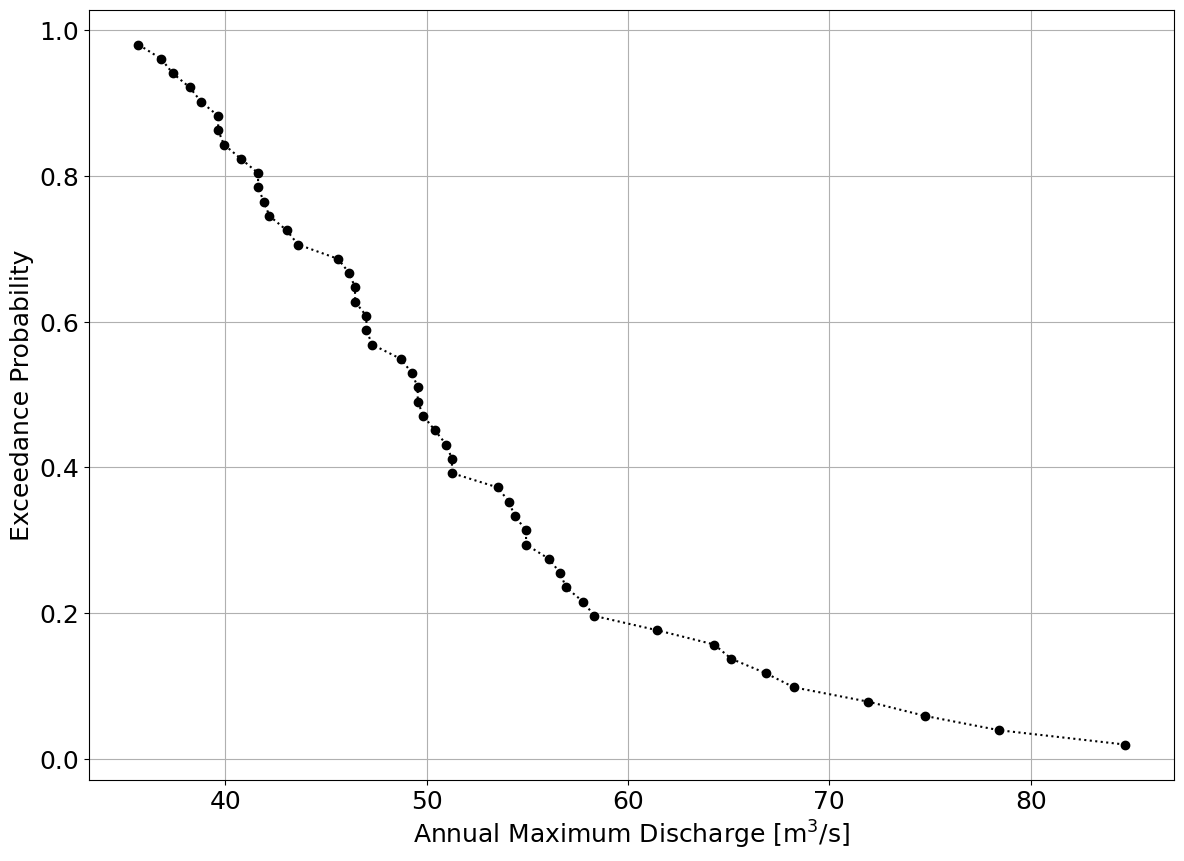

In [14]:
plt.figure(figsize = (14,10))
#plt.rcParams.update({'font.size': 18}) # Increase the font size
plt.plot(excDF["ams_discharge"], excDF["weibull_p"], "ko:")
plt.xlabel("Annual Maximum Discharge [m${}^3$/s]")
plt.ylabel("Exceedance Probability")
plt.grid()
plt.show()

In [15]:
p_ams = excDF["weibull_p"].values
p_ams


array([0.01960784, 0.03921569, 0.05882353, 0.07843137, 0.09803922,
       0.11764706, 0.1372549 , 0.15686275, 0.17647059, 0.19607843,
       0.21568627, 0.23529412, 0.25490196, 0.2745098 , 0.29411765,
       0.31372549, 0.33333333, 0.35294118, 0.37254902, 0.39215686,
       0.41176471, 0.43137255, 0.45098039, 0.47058824, 0.49019608,
       0.50980392, 0.52941176, 0.54901961, 0.56862745, 0.58823529,
       0.60784314, 0.62745098, 0.64705882, 0.66666667, 0.68627451,
       0.70588235, 0.7254902 , 0.74509804, 0.76470588, 0.78431373,
       0.80392157, 0.82352941, 0.84313725, 0.8627451 , 0.88235294,
       0.90196078, 0.92156863, 0.94117647, 0.96078431, 0.98039216])

In [16]:
arr = np.array(p_ams)

Q20 = np.interp(0.05, p_ams, Q_ams_sort)
Q20

76.41579814293058

In [17]:
Q50 = np.interp(0.02, p_ams, Q_ams_sort)
Q50

84.54586138059422

In [18]:
print('The 20-year flood event has a magnitude of {:.3f} m^3/s'.format(Q20))
print('The 50-year flood event has a magnitude of {:.3f} m^3/s'.format(Q50))

The 20-year flood event has a magnitude of 76.416 m^3/s
The 50-year flood event has a magnitude of 84.546 m^3/s
